# Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import shutil
import wandb
import matplotlib.pyplot as plt

from wandb.keras import WandbMetricsLogger, WandbCallback

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler

from keras import backend as K



# Loading the AVA dataset

## Normalize scores with range 1-5, get the MOS, save new CSV

In [2]:
# data_mos.to_csv('/media/workstation/BackupDrive/Dataset/AVA/AVA_MOS.csv')
ava_directory = '/media/workstation/BackupDrive/Dataset/AVA/'
img_dir = ava_directory + 'data_512x/'
data_mos = pd.read_csv('/media/workstation/BackupDrive/Dataset/multimodel_dataset/ava_multimodel_full_train_20_percent_val_test.csv', index_col='Index')

data_mos

,dataset,ID,1,2,3,4,5,6,7,8,9,10,sem1,sem2,challegeID,sum_score,total_scorer,MOS,scaled_MOS_aesthetic,set
Index,,,,,,,,,,,,,,,,,,,,
12,ava,953777.jpg,0,3,2,3,13,40,35,21,8,3,20,53,1396,844,128,6.593750,3.818291,training
21,ava,953550.jpg,0,0,1,3,13,45,36,20,5,7,14,0,1396,877,130,6.746154,3.908059,training
28,ava,954187.jpg,0,0,3,21,46,38,10,3,1,0,38,0,1396,654,122,5.360656,3.091981,training
83,ava,953933.jpg,0,0,9,19,63,25,9,2,1,1,15,19,1396,666,129,5.162791,2.975436,training
108,ava,953979.jpg,0,0,0,3,21,34,30,20,9,10,2,40,1396,872,127,6.866142,3.978733,training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123348,ava,263513.jpg,0,6,11,54,89,51,28,12,1,2,14,20,413,1333,254,5.248031,3.025644,test
81633,ava,577031.jpg,0,0,2,11,56,48,19,5,3,1,14,21,721,828,145,5.710345,3.297953,test
59759,ava,874523.jpg,3,15,22,37,61,46,23,8,9,2,18,41,1202,1154,226,5.106195,2.942100,test


### Convert the images in the files to 512x* with mogrify

mogrify -resize 512x /*.jpg

### Split images into train-validation-test directories 

In [3]:
data_mos_train = data_mos[data_mos['set'] == 'training']
display(data_mos_train)

data_mos_val = data_mos[data_mos['set'] == 'validation']
display(data_mos_val)

data_mos_test = data_mos[data_mos['set'] == 'test']
display(data_mos_test)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_mos_train, 
    directory=img_dir, 
    x_col="ID", 
    y_col="scaled_MOS_aesthetic", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=32
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=data_mos_test, 
    directory=img_dir, 
    x_col="ID", 
    y_col="scaled_MOS_aesthetic", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=32
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=data_mos_val, 
    directory=img_dir, 
    x_col="ID", 
    y_col="scaled_MOS_aesthetic", 
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=32
)

,dataset,ID,1,2,3,4,5,6,7,8,9,10,sem1,sem2,challegeID,sum_score,total_scorer,MOS,scaled_MOS_aesthetic,set
Index,,,,,,,,,,,,,,,,,,,,
12,ava,953777.jpg,0,3,2,3,13,40,35,21,8,3,20,53,1396,844,128,6.593750,3.818291,training
21,ava,953550.jpg,0,0,1,3,13,45,36,20,5,7,14,0,1396,877,130,6.746154,3.908059,training
28,ava,954187.jpg,0,0,3,21,46,38,10,3,1,0,38,0,1396,654,122,5.360656,3.091981,training
83,ava,953933.jpg,0,0,9,19,63,25,9,2,1,1,15,19,1396,666,129,5.162791,2.975436,training
108,ava,953979.jpg,0,0,0,3,21,34,30,20,9,10,2,40,1396,872,127,6.866142,3.978733,training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255415,ava,56748.jpg,38,58,54,44,37,9,0,1,1,1,1,18,181,758,243,3.119342,1.771816,training
255451,ava,57181.jpg,60,67,65,28,17,3,3,1,0,1,4,19,181,643,245,2.624490,1.480341,training
255452,ava,56722.jpg,0,3,5,8,30,58,62,38,20,20,19,21,181,1669,244,6.840164,3.963432,training


,dataset,ID,1,2,3,4,5,6,7,8,9,10,sem1,sem2,challegeID,sum_score,total_scorer,MOS,scaled_MOS_aesthetic,set
Index,,,,,,,,,,,,,,,,,,,,
130960,ava,933958.jpg,1,0,14,13,52,57,25,8,5,3,14,15,1341,1011,178,5.679775,3.279947,validation
132230,ava,754228.jpg,0,1,4,16,42,61,24,11,4,5,15,19,977,996,168,5.928571,3.426491,validation
36207,ava,278566.jpg,3,4,16,65,90,42,15,2,0,1,10,19,432,1152,238,4.840336,2.785506,validation
96134,ava,894565.jpg,0,1,6,18,54,40,6,3,0,1,20,21,1221,678,129,5.255814,3.030228,validation
234415,ava,209651.jpg,1,4,18,52,102,52,24,8,4,0,18,40,362,1361,265,5.135849,2.959567,validation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239542,ava,812703.jpg,1,0,4,7,52,43,21,4,1,0,2,0,1076,747,133,5.616541,3.242701,validation
74115,ava,355085.jpg,1,3,11,56,82,33,3,4,0,1,15,38,516,935,194,4.819588,2.773285,validation
242425,ava,96520.jpg,3,13,23,54,96,73,32,6,2,2,10,14,244,1542,304,5.072368,2.922176,validation


,dataset,ID,1,2,3,4,5,6,7,8,9,10,sem1,sem2,challegeID,sum_score,total_scorer,MOS,scaled_MOS_aesthetic,set
Index,,,,,,,,,,,,,,,,,,,,
34515,ava,914050.jpg,0,1,5,2,15,40,48,53,19,10,2,20,1281,1371,193,7.103627,4.118615,test
66231,ava,41959.jpg,1,0,4,14,26,52,24,10,5,4,18,22,146,844,140,6.028571,3.485393,test
173481,ava,650443.jpg,0,0,1,17,72,65,31,13,3,0,19,21,821,1169,202,5.787129,3.343180,test
158162,ava,220734.jpg,0,8,29,100,165,112,46,18,6,3,17,26,370,2550,487,5.236140,3.018639,test
104085,ava,444720.jpg,0,0,4,9,42,61,37,10,3,3,2,20,596,1020,169,6.035503,3.489476,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123348,ava,263513.jpg,0,6,11,54,89,51,28,12,1,2,14,20,413,1333,254,5.248031,3.025644,test
81633,ava,577031.jpg,0,0,2,11,56,48,19,5,3,1,14,21,721,828,145,5.710345,3.297953,test
59759,ava,874523.jpg,3,15,22,37,61,46,23,8,9,2,18,41,1202,1154,226,5.106195,2.942100,test


Found 19924 validated image filenames.
Found 2015 validated image filenames.
Found 2492 validated image filenames.


# Model Training (InceptionResNetV2)

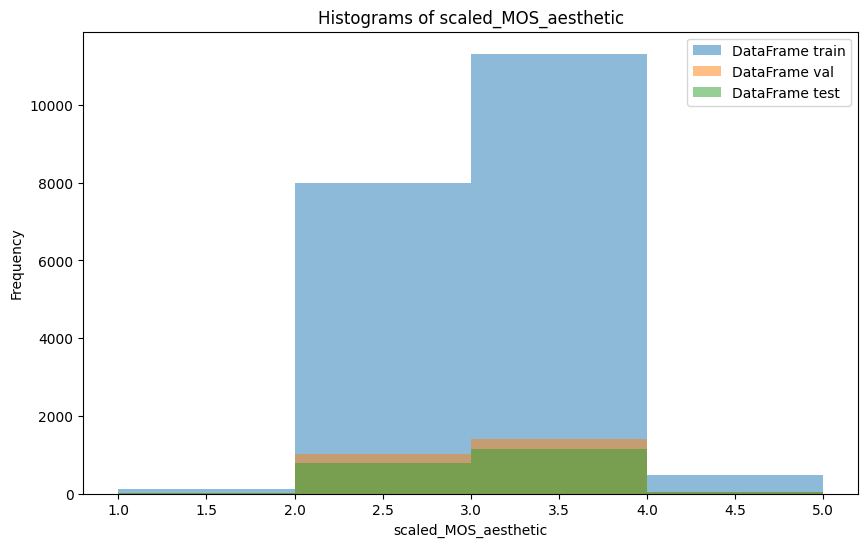

In [4]:
column_name = 'scaled_MOS_aesthetic'

# Plot histograms
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# DataFrame 1
plt.hist(data_mos_train[column_name], bins=4, alpha=0.5, range=(1,5), label='DataFrame train')

# DataFrame 2
plt.hist(data_mos_val[column_name], bins=4, alpha=0.5, range=(1,5), label='DataFrame val')

# DataFrame 3
plt.hist(data_mos_test[column_name], bins=4, alpha=0.5, range=(1,5), label='DataFrame test')

plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.title('Histograms of ' + column_name)
plt.legend()
plt.show()

## wandb configs

### Create the PLCC custom metric first

In [5]:
def plcc_tf(x, y):
    """PLCC metric"""
    xc = x - K.mean(x)
    yc = y - K.mean(y)
    return K.mean(xc*yc)/(K.std(x)*K.std(y) + K.epsilon())

def pearson_correlation(y_true, y_pred):
    # Subtract the mean from true and predicted values
    y_true_mean = K.mean(y_true)
    y_pred_mean = K.mean(y_pred)
    y_true_centered = y_true - y_true_mean
    y_pred_centered = y_pred - y_pred_mean

    # Calculate covariance and standard deviation
    covariance = K.mean(y_true_centered * y_pred_centered)
    y_true_std = K.std(y_true)
    y_pred_std = K.std(y_pred)

    # Calculate Pearson correlation coefficient
    pearson_coefficient = covariance / (y_true_std * y_pred_std + K.epsilon())

    return pearson_coefficient

In [6]:
class CustomMetricCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Calculate the custom metric
        y_true = self.validation_data[1]
        y_pred = self.model.predict(self.validation_data[0])
        pearson_coefficient = pearson_correlation(y_true, y_pred)

        # Log the custom metric using wandb
        wandb.log({"val_pearson_coefficient": pearson_coefficient})

In [7]:
wandb.init(
    # set the wandb project where this run will be logged
    project="baseline_ava_aesthetic",
    dir = "/media/workstation/BackupDrive/wandb_files/logs",

    # track hyperparameters and run metadata with wandb.config
    config={
        "fc1" : 2048,
        "activation1" : 'relu',
        "dropout1": 0.25,
        "fc2" : 1024,
        "activation2" : 'relu',
        "dropout2": 0.25,
        "fc3" : 256,
        "activation3" : 'relu',
        "dropout3": 0.5,
        "fc4" : 1,
        "activation4" : 'linear',
        "dropout4": 0,
        "learning_rate" : 0.001,
        "optimizer": "adam",
        "loss": "mean_squared_error",
        "metric": "root_mean_squared_error",
        "epoch": 100,
        "batch_size": 32,
        "metric2" : "val_pearson_correlation",
        "early_patience" : 20,
        "early_mode" : 'max',
        "early_min_delta" : 0.001,
        "plateau_patience" : 7,
        "plateau_mode" : "max",
        "plateau_factor" : 0.5,
        "plateau_min_lr" : 0.000001,
        "plateau_min_delta" : 0.01
    }
)

config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: ianchoo2000. Use `wandb login --relogin` to force relogin


In [8]:
# Load the InceptionResNetV2 model without pre-trained weights
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add your own top layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(config.fc1, activation=config.activation1)(x)
x = BatchNormalization()(x)
x = Dropout(config.dropout1)(x)

x = Dense(config.fc2, activation=config.activation2)(x)
x = BatchNormalization()(x)
x = Dropout(config.dropout2)(x)

x = Dense(config.fc3, activation=config.activation3)(x)
x = BatchNormalization()(x)
x = Dropout(config.dropout3)(x)

predictions = Dense(config.fc4, activation=config.activation4)(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

optimizer = keras.optimizers.Adam(learning_rate=config.learning_rate)

# Compile the model
model.compile(optimizer=optimizer,
              loss=config.loss,
              metrics=[tf.keras.metrics.RootMeanSquaredError(), pearson_correlation]
              )

checkpoint_filepath = '/media/workstation/BackupDrive/Dataset/AVA/data_512x_checkpoint/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_pearson_correlation',
    mode='max'
    )

early_stopping_callback = EarlyStopping(
    monitor= config.metric2, 
    patience=config.early_patience,
    mode=config.early_mode,
    min_delta = config.early_min_delta
    )

reduce_lr_callback = ReduceLROnPlateau(
    monitor = config.metric2,
    factor = config.plateau_factor,
    patience = config.plateau_patience,
    mode = config.plateau_mode,
    min_lr = config.plateau_min_lr
)

2023-07-08 23:35:28.879535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-08 23:35:28.884881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-08 23:35:28.885030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-08 23:35:28.885703: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
# Train the model with the preprocessed data
history = model.fit(train_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    epochs = config.epoch,
                    validation_data = val_generator,
                    validation_steps = len(val_generator),
                    callbacks = [
                      WandbMetricsLogger(log_freq=5),
                      WandbCallback(monitor='val_pearson_correlation', mode='max', save_model=False, save_weights_only=False),
                      model_checkpoint_callback,
                      early_stopping_callback,
                      reduce_lr_callback
                    ])

wandb.finish()

Epoch 1/100


2023-07-08 23:35:54.028906: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


622/622 [==============================] - 305s 465ms/step - loss: 2.8394 - root_mean_squared_error: 1.6851 - pearson_correlation: 0.0022 - val_loss: 1.2685 - val_root_mean_squared_error: 1.1263 - val_pearson_correlation: 0.0338 - lr: 0.0010
Epoch 2/100
622/622 [==============================] - 223s 358ms/step - loss: 0.7933 - root_mean_squared_error: 0.8907 - pearson_correlation: 0.0511 - val_loss: 0.1974 - val_root_mean_squared_error: 0.4443 - val_pearson_correlation: 0.2701 - lr: 0.0010
Epoch 3/100
622/622 [==============================] - 224s 360ms/step - loss: 0.4884 - root_mean_squared_error: 0.6989 - pearson_correlation: 0.1089 - val_loss: 0.1815 - val_root_mean_squared_error: 0.4260 - val_pearson_correlation: 0.3242 - lr: 0.0010
Epoch 4/100
622/622 [==============================] - 224s 360ms/step - loss: 0.3786 - root_mean_squared_error: 0.6153 - pearson_correlation: 0.1603 - val_loss: 0.1772 - val_root_mean_squared_error: 0.4209 - val_pearson_correlation: 0.4019 - lr: 0.0

batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,████████████████▄▄▄▄▄▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
batch/loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/pearson_correlation,▁▁▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▇▇▇████████████████████
batch/root_mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████████████████▄▄▄▄▄▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/pearson_correlation,▁▁▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▇▇▇████████████████████
epoch/root_mean_squared_error,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [10]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=data_mos_test, 
    directory=img_dir, 
    x_col="ID", 
    y_col="scaled_MOS_aesthetic", 
    shuffle = False,
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=32
)

Found 2015 validated image filenames.


In [11]:
# Evaluate the model on the preprocessed test data
evaluation = model.evaluate(
    test_generator,
    steps=len(test_generator)
)

63/63 [==============================] - 50s 807ms/step - loss: 0.1788 - root_mean_squared_error: 0.4228 - pearson_correlation: 0.4591


In [12]:
saved_model_path = '/media/workstation/BackupDrive/model/baseline_ava_aesthetic_firm_paper_14/'

model.save(saved_model_path + 'baseline_ava_aesthetic_firm_paper_14.h5')
model.save_weights(saved_model_path + 'baseline_ava_aesthetic_weights_gfirm_paper_14.h5')

# Predict baseline

In [13]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=data_mos_test, 
    directory=img_dir, 
    x_col="ID", 
    y_col="scaled_MOS_aesthetic", 
    shuffle = False,
    class_mode="raw", 
    target_size=(224, 224), 
    batch_size=1
)

Found 2015 validated image filenames.


In [14]:
import scipy 
from sklearn.metrics import mean_squared_error

def plcc(x, y):
    '''Pearson Linear Correlation Coefficient'''
    x, y = np.float32(x), np.float32(y)
    return scipy.stats.pearsonr(x,y)[0]

def srocc(xs, ys):
    '''Spearman Rank Order Correlation Coefficient'''
    correlation, p_value = scipy.stats.spearmanr(xs, ys)
    return correlation

def rmse(y_test, y_pred):
    mse = np.mean((y_test - y_pred) ** 2)
    return np.sqrt(mse)
    

In [15]:
prediction = model.predict(
    test_generator,
    steps=len(test_generator)
)

SRCC/PLCC/RMSE 0.479/0.433/0.423


Text(0.5, 0.98, 'Quality Score Ground truth - Prediction')

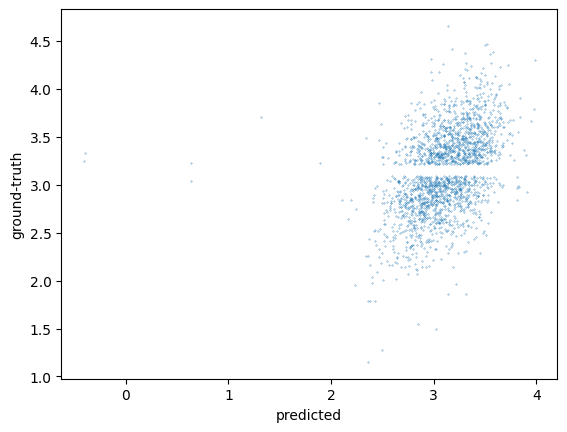

<Figure size 640x480 with 0 Axes>

In [16]:
# prediction
test_list = prediction.tolist()
test_list = [val[0] for val in test_list]
len(test_list)

# data_mos_test
test_1 = data_mos_test.copy()
test_1['pred_value'] = test_list
test_1

y_test = np.array(test_1.loc[:, 'scaled_MOS_aesthetic'])
y_pred = np.array(test_1.loc[:, 'pred_value'])

SRCC_test = round(srocc(y_pred, y_test), 3)
PLCC_test = round(plcc(y_pred, y_test), 3)
rmse_test = round(rmse(y_test, y_pred), 3)
print('SRCC/PLCC/RMSE {}/{}/{}'.format(SRCC_test, PLCC_test, rmse_test))

plt.plot(y_pred, y_test, '.', markersize=0.5)
plt.xlabel('predicted'); plt.ylabel('ground-truth'); plt.show
fig = plt.figure()
fig.suptitle('Quality Score Ground truth - Prediction')

In [17]:
test_1.to_csv('prediction_baseline_ava_aesthetic_firm_paper_14.csv')